## Image Classification using CNN

In [10]:
import os
import zipfile
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop
import matplotlib.pyplot as plt
import tensorflow as tf

In [11]:
train_dir = 'tourism_destination_2/tourism_destination/train_data/'
validation_dir = 'tourism_destination_2/tourism_destination/validation_data/'

In [24]:
# Data Augmentation
train_datagen = ImageDataGenerator(
      rescale = 1./255,
      rotation_range=30,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

train_generator = train_datagen.flow_from_directory( 
        train_dir, 
        target_size=(150, 150), 
        batch_size=16,
        class_mode='categorical')

# genereate 100 augmantation
augmentation_count = 200

for i in range(augmentation_count):
    # take image batch from generator
    batch_images, batch_labels = train_generator.next()

test_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=16,
        class_mode='categorical') 

Found 1233 images belonging to 16 classes.
Found 273 images belonging to 16 classes.


In [22]:
#Build a Model
def create_model():
    model = tf.keras.models.Sequential([
      tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
      tf.keras.layers.MaxPooling2D(2, 2),
      tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dropout(0.5),
      tf.keras.layers.Dense(512, activation='relu'),
      tf.keras.layers.Dense(16, activation='softmax')
    ])

    model.compile(loss='categorical_crossentropy',
                optimizer=RMSprop(learning_rate=1e-4), #experiment with lr = 1e-2, 1e-5 and 1e-6 stuck in local minimum (acc=2.55xxx)
                metrics=['accuracy'])
  
    return model

model=create_model()
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 74, 74, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 36, 36, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_18 (Conv2D)          (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 17, 17, 128)     

In [23]:
from keras.callbacks import History

# Create an instance of the History callback
history_callback = History()

In [25]:
history = model.fit(   
      train_generator,
      epochs=250,
      steps_per_epoch=1233 // 16,
      validation_data=validation_generator,
      validation_steps=273//16, 
      verbose=2,
      callbacks=[history_callback])

Epoch 1/250
77/77 - 33s - loss: 2.6863 - accuracy: 0.1167 - val_loss: 2.6232 - val_accuracy: 0.2206 - 33s/epoch - 427ms/step
Epoch 2/250
77/77 - 30s - loss: 2.6172 - accuracy: 0.1726 - val_loss: 2.4813 - val_accuracy: 0.1949 - 30s/epoch - 386ms/step
Epoch 3/250
77/77 - 30s - loss: 2.4941 - accuracy: 0.2120 - val_loss: 2.3937 - val_accuracy: 0.2096 - 30s/epoch - 390ms/step
Epoch 4/250
77/77 - 30s - loss: 2.4096 - accuracy: 0.2375 - val_loss: 2.1232 - val_accuracy: 0.3493 - 30s/epoch - 392ms/step
Epoch 5/250
77/77 - 30s - loss: 2.3042 - accuracy: 0.2671 - val_loss: 2.1268 - val_accuracy: 0.3309 - 30s/epoch - 392ms/step
Epoch 6/250
77/77 - 30s - loss: 2.2427 - accuracy: 0.2917 - val_loss: 1.9344 - val_accuracy: 0.4118 - 30s/epoch - 384ms/step
Epoch 7/250
77/77 - 30s - loss: 2.1674 - accuracy: 0.3048 - val_loss: 1.9059 - val_accuracy: 0.3713 - 30s/epoch - 384ms/step
Epoch 8/250
77/77 - 29s - loss: 2.1241 - accuracy: 0.3172 - val_loss: 1.8107 - val_accuracy: 0.4632 - 29s/epoch - 379ms/step


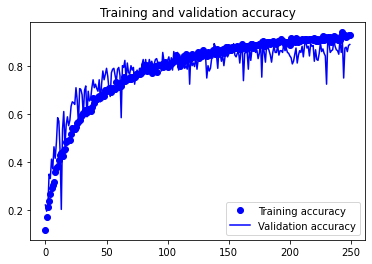

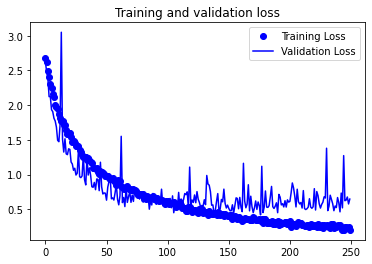

In [27]:
# plot the summary training
def plot_loss_acc(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'bo', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure()

    plt.plot(epochs, loss, 'bo', label='Training Loss')
    plt.plot(epochs, val_loss, 'b', label='Validation Loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

plot_loss_acc(history)

In [28]:
# Save the entire model
model.save("model15.h5")

# Save only the model weights
model.save_weights("weights15.h5")


import json

history = history_callback.history

# Save the history dictionary to a JSON file
with open('epoch_history15.json', 'w') as f:
    json.dump(history, f)

In [29]:
model = tf.keras.models.load_model('model15.h5')
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the TFLite model to a file
with open('model15.tflite', 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\CATURW~1\AppData\Local\Temp\tmpydjfncqi\assets


INFO:tensorflow:Assets written to: C:\Users\CATURW~1\AppData\Local\Temp\tmpydjfncqi\assets
